In [1]:
from fairsearchcore.models import FairScoreDoc
import math
import sys
import warnings
warnings.filterwarnings("ignore")
import fairsearchcore as fsc
import sys
import numpy as np
import pandas as pd


In [3]:
%store -r queries_uk_l
%store -r df_u1

In [6]:
def build_ranking_model(is_protected_list):
    size = len(is_protected_list)
    unfair_ranking = []
    for i in range(size):
        unfair_ranking.append(FairScoreDoc((size-i), (size-i), is_protected_list[i]))
    return unfair_ranking

In [7]:
def is_ranking_fair(ranking, p, k, alpha=0.1):
    #k = 20 # number of topK elements returned (value should be between 10 and 400)
    #p = 0.1 # proportion of protected candidates in the topK elements (value should be between 0.02 and 0.98) 
    #alpha = 0.1 # significance level (value should be between 0.01 and 0.15)
    
    fair = fsc.Fair(k, p, alpha)
    return fair.is_fair(ranking)

In [8]:
def get_min_size_elements(df, queries, source, country, min_elements=10, tag_name='query'):
    min_size = float('inf')
    min_query = ""
    """
    print("{: >20} {: >10}".format("Query","Size"))
    print("-----------------------------------------")
    """

    for q in queries:
        size = len(df[(df[tag_name]==q) & (df['source'] == source) ])
        print(size)
        print(q)

        if (size < min_size) and (size >= min_elements):
            min_size = size
            print (min_size)

            min_query = q
            print (q)
            print("\n")
            print("{: >20} {: >10}".format(q,size))
    
    
    print("\n")
    print("{: >20} {: >10}".format(q,size))
    
    return min_size

In [9]:
def sex_discrimination(row, protected_sex='female'):
    
#    return (row['gender'] == protected_sex or None or 'unknown')        
    return row['gender'] == protected_sex         
#    return row['gender'] != 'male'         



def experience_discrimination(row, protected_value = 'senior2-level'):
    protected_value = translate_if_foreigner(protected_value)
    return row['experience_level'] == protected_value 


In [10]:
def get_fairness_metrics(df, queries, source, country, discrimination_function, positional_arguments, n, tag_name='query'):
    protected_lists = []
    q_list=[]
    p_max_list=[]
    p_values = [0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98]
    print("{: >15} {: >10}".format("Query","p = True"))
    print('          '+'-'*20)
    if discrimination_function == old_age_discrimination or discrimination_function == young_age_discrimination:
        median = 35
        print("Median age= ",median)

    for q in sorted(list(queries)):
        df_u1_res = df[(df[tag_name] == q) & (df['source'] == source) & (df['country'] == country)].sort_values('#')[:n]
        df_u1_res.head()
        if len(df_u1_res) == n: # if it has the minimum number of elements (minimum number of elements without unknowns for all queries)
            is_protected_list = []
            for i in range(len(df_u1_res)):
                if discrimination_function == old_age_discrimination or discrimination_function == young_age_discrimination:
                    condition = discrimination_function(df_u1_res.iloc[i], median)
                else:
                    condition = discrimination_function(df_u1_res.iloc[i],positional_arguments['protected_value'])
                if condition:
                    is_protected_list.append(True)
                else:
                    is_protected_list.append(False)
            #print(is_protected_list)
            protected_lists.append(is_protected_list)
            ranking = build_ranking_model(is_protected_list)

            is_fair_list = list([bool(is_ranking_fair(ranking,p, n)) for p in p_values])
            if True in is_fair_list:
                p_index = len(is_fair_list) - 1 - is_fair_list[::-1].index(True)
                p_max = p_values[p_index]
            else:
                p_max = "-"
            #print(is_fair_list)
            if len(q) > 15: 
                q = q[:11]+'.'
            print("{: >15} {: >10}".format(q,p_max))
            q_list.append(q)
            p_max_list.append(p_max)
    return q_list,p_max_list

In [11]:
#df_u1_sex_filtered=df_u1
df_u1_sex_filtered = df_u1[(df_u1['gender'] != None) & (df_u1['gender'] != 'unknown')]
df_u1_age_filtered = df_u1[df_u1.age.notnull() & df_u1.age.dropna()]
df_u1_nationality_filtered = df_u1[df_u1.Is_foreigner.notnull() &  (df_u1['Is_foreigner']!='unknown') & (df_u1['Is_foreigner']!='tooshort')]
df_u1_photo_filtered = df_u1[df_u1.has_photo.notnull()]
df_u1_premium_filtered = df_u1[df_u1.is_premium.notnull()]
df_u1_experience_filtered = df_u1[(df_u1['experience_level'] != None) & (df_u1['experience_level'] != 'unknown')]

In [12]:
min_size=15

In [13]:
def experience_to_number(argument): 
    switcher = { 
        "senior2-level":0.85, 
        'senior1-level':0.80, 
        'mid-level':0.75,
        'entry-level':0.70,
    }  
    return switcher.get(argument, 0.60) 

In [19]:
med_famel=0
med_male=0

famel_num_l=[]
male_num_l=[]
male_exp_l=[]
famel_exp_l=[]
diff_avg_relevance_l=[]

for q in sorted(queries_uk_l):
    count_famel=0
    count_male=0
    famel_exp=0
    male_exp=0
    diff_avg_relevance=0.0
    quary=q 
    df_15 = df_u1_sex_filtered[(df_u1_sex_filtered['query'] == q) & (df_u1_sex_filtered['source'] == 'linkedin')].sort_values('#')[:15]
    for index, row in df_15.iterrows():
        if (row['gender'] == 'female'):
            count_famel=count_famel+1
            
            famel_exp=famel_exp+experience_to_number(row['experience_level'])
        elif (row['gender'] == 'male'):
            count_male=count_male+1
            male_exp=male_exp+experience_to_number(row['experience_level'])
        else:
            continue
    print(q)
    if(count_famel!=0):
        med_famel=round(famel_exp/count_famel,2)
    if(count_male!=0):
        med_male=round(male_exp/count_male,2)
    diff_avg_relevance=round(abs(med_famel-med_male),2)

    print('count_famel',count_famel) 
    print('count_male',count_male)    
    print('med_male',med_male)    
    print('med_famel',med_famel) 
    print('diff_avg_relevance',diff_avg_relevance)    

    male_exp_l.append(med_male)
    famel_exp_l.append(med_famel)
    diff_avg_relevance_l.append(diff_avg_relevance)

    new_row ={'query':q, 'famel_med_bia':med_famel, 'male_med_bia':med_male}
            #append row to the dataframe
#    my_df.append(new_row,ignore_index=True)

architect
count_famel 9
count_male 6
med_male 0.81
med_famel 0.81
diff_avg_relevance 0.0
chef
count_famel 5
count_male 10
med_male 0.81
med_famel 0.82
diff_avg_relevance 0.01
consultant
count_famel 7
count_male 8
med_male 0.82
med_famel 0.78
diff_avg_relevance 0.04
dentist
count_famel 7
count_male 8
med_male 0.81
med_famel 0.81
diff_avg_relevance 0.0
designer
count_famel 8
count_male 7
med_male 0.83
med_famel 0.79
diff_avg_relevance 0.04
developer
count_famel 6
count_male 9
med_male 0.81
med_famel 0.78
diff_avg_relevance 0.03
doctor
count_famel 7
count_male 8
med_male 0.77
med_famel 0.81
diff_avg_relevance 0.04
economist
count_famel 7
count_male 8
med_male 0.82
med_famel 0.82
diff_avg_relevance 0.0
engineer
count_famel 5
count_male 10
med_male 0.8
med_famel 0.81
diff_avg_relevance 0.01
firefighter
count_famel 3
count_male 12
med_male 0.8
med_famel 0.85
diff_avg_relevance 0.05
gardener
count_famel 2
count_male 13
med_male 0.78
med_famel 0.82
diff_avg_relevance 0.04
hairdresser
count_fam

In [23]:
exp_medList = pd.DataFrame(
    {'M_AVR': male_exp_l,
     'F_AVR': famel_exp_l,
    'diff_avg_relevance':diff_avg_relevance_l}, index=queries_uk_l)

In [25]:
export_csv = exp_medList.to_csv (r'difference_in_avg_relevancemm.csv', header=True) #Don't forget to add '.csv' at the end of the path


In [92]:
exp_medList_split = np.array_split(exp_medList, 3)

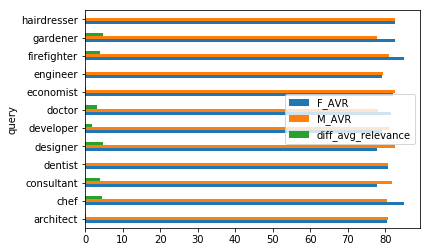

In [93]:
ax = exp_medList_split[0].plot.barh(rot=0)

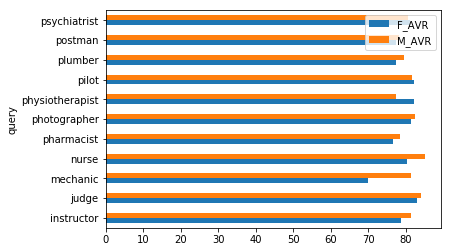

In [30]:
ax = exp_medList_split[1].plot.barh(rot=0)

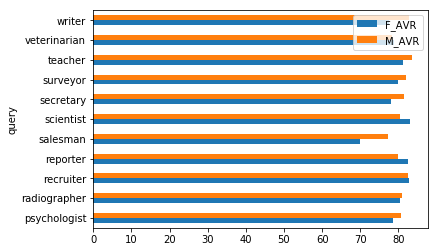

In [31]:
ax = exp_medList_split[2].plot.barh(rot=0)

In [52]:
def get_bias(i): 
    log2 = math.log2(i+1)
    return  1/log2

In [94]:
famel_num_l=[]
male_num_l=[]
male_bia_l=[]
famel_bia_l=[]
diff_avg_exposure_l=[]
for q in sorted(queries_uk_l):  
    diff_avg_exposure=0.0    
    count=0
    med_famel=0.0
    med_male=0.0
    count_famel=0
    count_male=0
    famel_bais=0
    male_bais=0
    quary=q 
    df_15 = df_u1_sex_filtered[(df_u1_sex_filtered['query'] == q) & (df_u1_sex_filtered['source'] == 'linkedin')].sort_values('#')[:15]
    for index, row in df_15.iterrows():
        
        if (row['gender'] == 'female'):
            count=count+1
            famel_bais=famel_bais+get_bias(count)
            count_famel=count_famel+1
            #print ('count',count)
            #print ('famel_bais',famel_bais)
            
        elif (row['gender'] == 'male'):
            count=count+1
            male_bais=male_bais+get_bias(count)
            count_male=count_male+1

            #print ('count',count)
            #print ('male_bais',male_bais)
            
        else:
            continue
    print(q)
    if(count_famel!=0):
        med_famel=round(famel_bais/count_famel,2)
    if(count_male!=0):
        med_male=round(male_bais/count_male,2)
    diff_avg_exposure=round(abs(med_famel-med_male),2)
#    print('count_famel',count_famel) 
#    print('count_male',count_male)    
    print('famel_bais',med_famel)
    print('male_bais',med_male)  
    print('diff_avg_exposure',diff_avg_exposure)    

    male_bia_l.append(med_male)
    famel_bia_l.append(med_famel)
    diff_avg_exposure_l.append(diff_avg_exposure)
    #new_row ={'query':q, 'famel_num':count_famel, 'male_num':count_male, 'famel_exp':famel_exp, 'male_exp':male_exp}
            #append row to the dataframe
    #my_df.append(new_row,ignore_index=True)
            

architect
famel_bais 0.41
male_bais 0.35
diff_avg_exposure 0.06
chef
famel_bais 0.39
male_bais 0.39
diff_avg_exposure 0.0
consultant
famel_bais 0.36
male_bais 0.42
diff_avg_exposure 0.06
dentist
famel_bais 0.31
male_bais 0.49
diff_avg_exposure 0.18
designer
famel_bais 0.45
male_bais 0.3
diff_avg_exposure 0.15
developer
famel_bais 0.37
male_bais 0.4
diff_avg_exposure 0.03
doctor
famel_bais 0.38
male_bais 0.4
diff_avg_exposure 0.02
economist
famel_bais 0.35
male_bais 0.43
diff_avg_exposure 0.08
engineer
famel_bais 0.28
male_bais 0.46
diff_avg_exposure 0.18
firefighter
famel_bais 0.52
male_bais 0.34
diff_avg_exposure 0.18
gardener
famel_bais 0.29
male_bais 0.41
diff_avg_exposure 0.12
hairdresser
famel_bais 0.43
male_bais 0.29
diff_avg_exposure 0.14
instructor
famel_bais 0.44
male_bais 0.34
diff_avg_exposure 0.1
judge
famel_bais 0.47
male_bais 0.35
diff_avg_exposure 0.12
mechanic
famel_bais 0.29
male_bais 0.4
diff_avg_exposure 0.11
nurse
famel_bais 0.42
male_bais 0.29
diff_avg_exposure 0.1

In [95]:
expA_medList = pd.DataFrame(
    {'M_AVE': male_bia_l,
     'F_AVE': famel_bia_l,
    'diff_avg_exposure':diff_avg_exposure_l}, index=queries_uk_l)

In [61]:
expA_medList_split = np.array_split(expA_medList, 3)


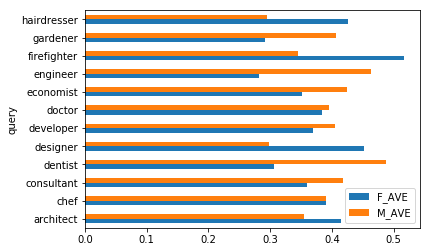

In [62]:
ax = expA_medList_split[0].plot.barh(rot=0)

In [63]:
expA_medList_split[0].head

<bound method NDFrame.head of                 F_AVE     M_AVE
query                          
architect    0.414617  0.354966
chef         0.391313  0.390554
consultant   0.359363  0.418226
dentist      0.306519  0.487028
designer     0.452586  0.298012
developer    0.369528  0.404909
doctor       0.384804  0.395965
economist    0.351168  0.425397
engineer     0.282006  0.463257
firefighter  0.516882  0.344893
gardener     0.291667  0.406001
hairdresser  0.425793  0.294408>

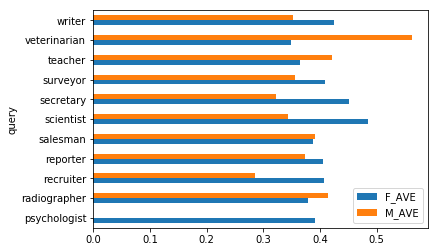

In [64]:
ax = expA_medList_split[2].plot.barh(rot=0)

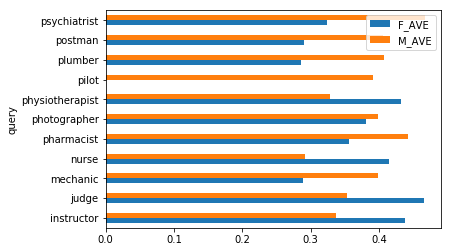

In [65]:
ax = expA_medList_split[1].plot.barh(rot=0)

In [96]:
export_csv = expA_medList.to_csv (r' difference_in_avg_exposure.csv', header=True) #Don't forget to add '.csv' at the end of the path


In [73]:
rsult=pd.concat([expA_medList, exp_medList], axis=1)


In [75]:
rsult_split = np.array_split(rsult, 3)


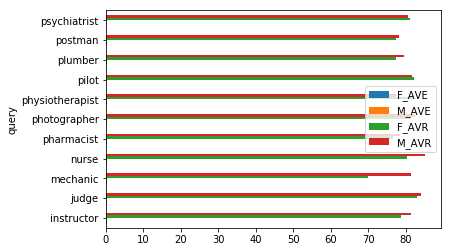

In [77]:
ax = rsult_split[1].plot.barh(rot=0)

In [98]:
Diff_between_exp_rel = pd.DataFrame(
    {'diff_avg_relevance':diff_avg_relevance_l,
    'diff_avg_exposure':diff_avg_exposure_l}, index=queries_uk_l)

In [101]:
export_csv = Diff_between_exp_rel.to_csv (r' Diff_between_exp_rel.csv', header=True) #Don't forget to add '.csv' at the end of the path


In [102]:
Diff_between_exp_rel_splited = np.array_split(Diff_between_exp_rel, 3)


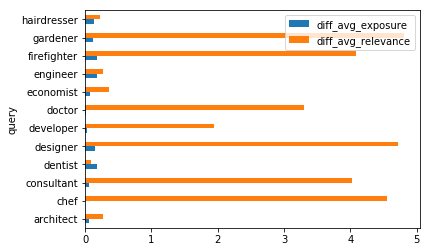

In [103]:
ax = Diff_between_exp_rel_splited[0].plot.barh(rot=0)

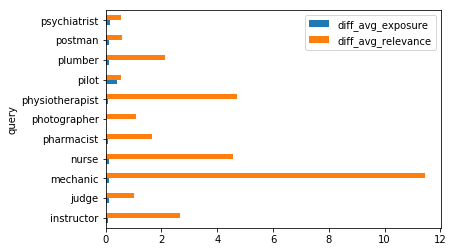

In [104]:
ax = Diff_between_exp_rel_splited[1].plot.barh(rot=0)

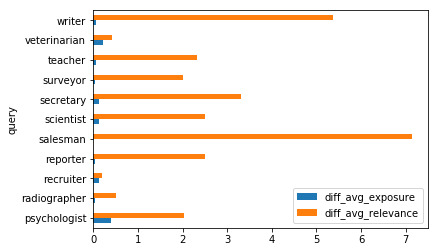

In [105]:
ax = Diff_between_exp_rel_splited[2].plot.barh(rot=0)